## Import data, set logging level

In [12]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
from deepmeg.utils.viz import plot_metrics
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp

In [4]:
def accuracy(predictions, targets):

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy

## Reading Epochs and preprocessing

In [3]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
info = mne.io.read_raw_fif(fname_raw).pick_types(meg='grad').resample(600).info

## Split the dataset into train and test sets

In [5]:
dataset = read_epochs_dataset('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [6]:
X, Y = next(iter(DataLoader(train)))

In [25]:
class LFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = self.temp_conv(x.permute(0, -1, 1))
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

LFCNN(204, 301, 8, 50, 10, 8)(X)

tensor([[ 0.1670,  0.0869,  0.2253, -0.1425, -0.1006,  0.0317,  0.1820, -0.0111]],
       grad_fn=<AddmmBackward0>)

(10, 100, 1000)
Original data shape: (10, 100, 1000)
Whitened data shape: torch.Size([10, 100, 1000])


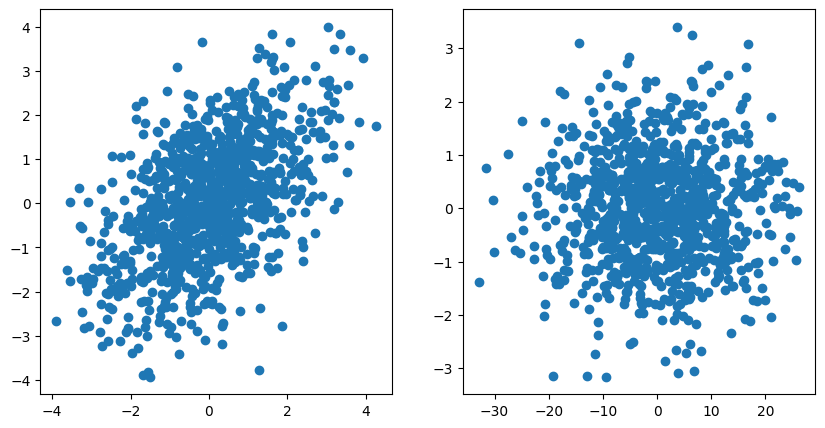

In [27]:
import torch
import torch.nn as nn

class BatchWhitening1D(nn.Module):
    def __init__(self):
        super(WhiteningLayer, self).__init__()

    def forward(self, X):
        N_batches, N_sources, N_times = X.shape
        X = X.permute(1, 2, 0).reshape(N_sources, -1).t()
        X_centered = X - torch.mean(X, dim=0)

        # Compute the covariance matrix
        cov_matrix = torch.mm(X_centered.T, X_centered) / (X_centered.shape[0] - 1)

        # Compute the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eig(cov_matrix)
        eigenvalues = eigenvalues.real  # Keep only the real part of eigenvalues
        eigenvectors = eigenvectors.real  # Keep only the real part of eigenvectors

        # Sort the eigenvalues and eigenvectors
        sorted_indices = torch.argsort(eigenvalues, descending=True)
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Normalize the eigenvectors
        eigenvectors = eigenvectors / torch.norm(eigenvectors, dim=0)

        # Whiten the data
        X_whitened = torch.mm(X_centered, eigenvectors)
        X_whitened = X_whitened.t().view(N_sources, N_times, N_batches).permute(2, 0, 1)

        return X_whitened

# Example usage
n_batches = 10
n_sources = 100
n_times = 1000
X = torch.randn(n_batches, n_sources, n_times)
X = np.random.multivariate_normal(np.zeros(n_sources), np.eye(n_sources) + 1, size=(n_batches, n_times)).transpose(0, 2, 1)
print(X.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(X[0, 0, :], X[0, 1, :])

whitening_layer = WhiteningLayer()
X_whitened = whitening_layer(torch.tensor(X))


ax2.scatter(X_whitened[0, 0, :], X_whitened[0, 1, :])
print("Original data shape:", X.shape)
print("Whitened data shape:", X_whitened.shape)


In [28]:
class LFCNNr(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        select_n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.select_n_latent = select_n_latent
        self.temp_conv = nn.Conv1d(self.select_n_latent, self.select_n_latent, kernel_size=filter_size, bias=True, groups=self.select_n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*self.select_n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*self.select_n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = x.permute(0, -1, 1)
        x = x[:, :self.select_n_latent]
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)


LFCNNr(204, 301, 8, 8, 50, 10, 8)(torch.rand((1, 204, 301)))

tensor([[-0.0662, -0.1330,  0.0301,  0.1326, -0.0900, -0.0498,  0.0115, -0.1727]],
       grad_fn=<AddmmBackward0>)

In [130]:
X.shape

torch.Size([2000, 2])

In [16]:
from deepmeg.utils.viz import plot_metrics
from deepmeg.experimental.layers import LW


class LFCNNWr(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        select_n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        # self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.select_n_latent = select_n_latent
        self.temp_conv = nn.Conv1d(self.select_n_latent, self.select_n_latent, kernel_size=filter_size, bias=True, groups=self.select_n_latent, padding='same')
        # self.temp_sel = nn.ModuleList([LW(n_times) for _ in range(self.select_n_latent)])
        final_out_features = (n_times//pool_factor)*self.select_n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*self.select_n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        # x = self.unmixing_layer(x)
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = x.permute(0, -1, 1)
        x = x[:, :self.select_n_latent]
        x = self.temp_conv(x)
        # x = torch.stack([lw(x[:, branch_n, :]) for lw, branch_n in zip(self.temp_sel, range(self.n_latent))], -2)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [18]:
from deepmeg.training.callbacks import Callback


class IndependanceConstraint(Callback):
    def __init__(self, n_latent: int):
        self.n_latent = n_latent
        self.eye = torch.eye(self.n_latent)
        super().__init__()

    def set_trainer(self, trainer: 'Trainer'):
        super().set_trainer(trainer)
        self.model = self.trainer.model

    def on_loss_computed(self, X, Y, Y_pred, loss, is_training=True):

        if is_training:
            # x = self.model.unmixing_layer(X)
            # x = x.permute(1, 0, -1)

            x = self.model.unmixing_layer(X.permute(0, -1, 1))
            x = x.permute(-1, 0, 1)

            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
            s = torch.corrcoef(x)
            err = (((s - self.eye)**2)/self.n_latent**2).sum()
            # err = ((torch.abs(s - self.eye))/self.n_latent).sum()

            loss += err

        return loss


class WeightClipper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, module):
        self.model.temp_conv.weight -= self.model.temp_conv.weight.mean(-1, keepdim=True)


class TempConvAveClipping(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.clipper = WeightClipper(self.model)

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.model.apply(self.clipper)


In [19]:
X.shape

torch.Size([1, 204, 301])

In [40]:
model = LFCNNr(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=9, # ~ number of latent factors
    select_n_latent=8,
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        # TempConvAveClipping(),
        # IndependanceConstraint(16),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [41]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7189   |    accuracy_train:  0.1105   |    loss_val:  0.6995   |    accuracy_val:  0.1156
Epoch 1:  loss_train:  0.6935   |    accuracy_train:  0.1423   |    loss_val:  0.6790   |    accuracy_val:  0.1208
Epoch 2:  loss_train:  0.6691   |    accuracy_train:  0.1779   |    loss_val:  0.6575   |    accuracy_val:  0.1312
Epoch 3:  loss_train:  0.6434   |    accuracy_train:  0.2056   |    loss_val:  0.6336   |    accuracy_val:  0.1590
Epoch 4:  loss_train:  0.6156   |    accuracy_train:  0.2191   |    loss_val:  0.6070   |    accuracy_val:  0.1808
Epoch 5:  loss_train:  0.5857   |    accuracy_train:  0.2382   |    loss_val:  0.5782   |    accuracy_val:  0.2030
Epoch 6:  loss_train:  0.5545   |    accuracy_train:  0.2551   |    loss_val:  0.5485   |    accuracy_val:  0.2142
Epoch 7:  loss_train:  0.5236   |    accuracy_train:  0.2907   |    loss_val:  0.5200   |    accuracy_val:  0.2416
Epoch 8:  loss_train:  0.4946   |    accuracy_train:  0.3227   |    loss_val:  0

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

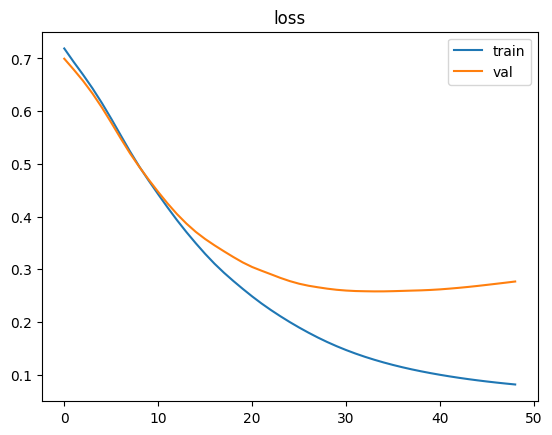

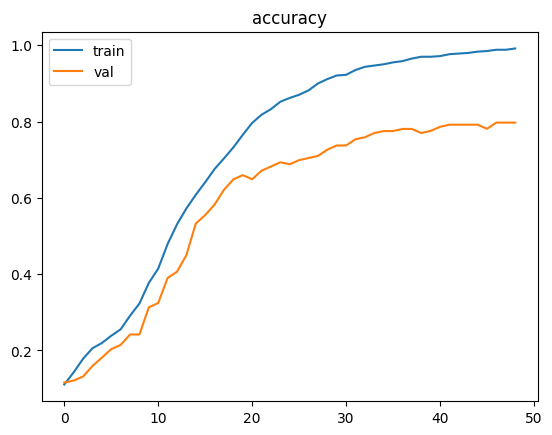

In [42]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [43]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.15507101741704074
train_accuracy: 0.9047202847220681
loss: 0.26053585518490185
accuracy: 0.7467532428828153


## Model interpretation

In [67]:
from deepmeg.interpreters import LFCNNInterpreter
from deepmeg.utils.viz import generate_cmap
from deepmeg.experimental.interpreters import LFCNNWInterpreter, SPIRITInterpreter

class LFCNNWrInterpreter(SPIRITInterpreter):
    @torch.no_grad()
    def compute_branchwise_loss(self):
        loader = DataLoader(self.dataset, len(self.dataset))
        base_loss = self.model.evaluate(loader)['loss']
        n_latent = self.model.unmixing_layer.weight.shape[0]

        losses = list()
        for i in range(n_latent):
            branch_unmixing_weights_original = deepcopy(self.model.unmixing_layer.weight[i, :, :])
            self.model.unmixing_layer.weight[i, :, :] = 0

            if self.model.unmixing_layer.bias is not None:
                branch_unmixing_bias_original = deepcopy(self.model.unmixing_layer.bias[i])
                self.model.unmixing_layer.bias[i] = 0
            if self.model.temp_conv.bias is not None and i < self.model.select_n_latent:
                branch_temp_conv_bias_original = deepcopy(self.model.temp_conv.bias[i])
                self.model.temp_conv.bias[i] = 0

            losses.append(self.model.evaluate(loader)['loss'])
            self.model.unmixing_layer.weight[i, :, :] = branch_unmixing_weights_original

            if self.model.unmixing_layer.bias is not None:
                self.model.unmixing_layer.bias[i] = branch_unmixing_bias_original
            if self.model.temp_conv.bias is not None and i < self.model.select_n_latent:
                self.model.temp_conv.bias[i] = branch_temp_conv_bias_original

        return base_loss - np.array(losses)
    @torch.no_grad()
    def compute_temporal(self):
        loader = DataLoader(self.dataset, len(self.dataset))
        n_latent = self.model.unmixing_layer.weight.shape[0]
        x, y = next(iter(loader))

        x = self.model.unmixing_layer(x)
        x = x[:, :self.model.select_n_latent]
        x = self.model.temp_conv(x)
        temporal_patterns, latent_sources_weighted = list(), list()
        zeros = None
        for i, lw in enumerate(self.model.temp_sel):
            source = x[:, i, :]
            x1 = source*lw.w1 + lw.b
            x2 = torch.sigmoid(source*lw.w2)
            temporal_patterns.append(x2[:, ::self.model.pool_factor].contiguous())
            latent_sources_weighted.append(x1*x2)
            if zeros is None:
                zeros = (torch.zeros_like(x2[:, ::self.model.pool_factor]), torch.zeros_like(x1))
        for i in range(self.model.n_latent - self.model.select_n_latent):
            temporal_patterns.append(zeros[0])
            latent_sources_weighted.append(zeros[1])
        return torch.stack(temporal_patterns, -2).numpy(), torch.stack(latent_sources_weighted, -2).numpy()

    @torch.no_grad()
    def compute_patterns(self):
        x, y = next(iter(DataLoader(self.dataset, len(self.dataset))))
        x_flatten = x.reshape(x.shape[1], x.shape[0]*x.shape[-1])
        latent_sources = self.model.unmixing_layer(x)
        latent_sources_filtered = self.model.temp_conv(latent_sources[:, :self.model.select_n_latent])
        # latent_sources_flatten = latent_sources_filtered.permute(1, 0, -1)
        # latent_sources_flatten = latent_sources_flatten.reshape(latent_sources_flatten.shape[0], latent_sources_flatten.shape[1]*latent_sources_flatten.shape[2])
        self._latent_sources = latent_sources.numpy()
        self._latent_sources_filtered = latent_sources_filtered.numpy()
        self._latent_sources_filtered = np.concatenate([self._latent_sources_filtered, np.zeros_like(self._latent_sources[:, self.model.select_n_latent:])], axis=1)
        unmixing_matrix = self.model.unmixing_layer.weight.numpy()[:, :, 0]
        filters = unmixing_matrix.T
        # covariance of latent_sources should aim to I, due to linear independance
        x = x.permute(1, 0, -1)
        x_flatten = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
        patterns = list()

        for comp_num in range(len(self.model.unmixing_layer.weight)):
            x_filt_flatten = torch.zeros_like(x_flatten)

            for ch_num in range(x.shape[0]):
                if comp_num < len(self.model.temp_conv.weight):
                    x_filt_flatten[ch_num] = torch.nn.functional.conv1d(
                        torch.unsqueeze(x_flatten[ch_num], 0),
                        torch.unsqueeze(self.model.temp_conv.weight[comp_num].detach(), 0),
                        padding='same'
                    )
                else:
                    x_filt_flatten[ch_num] = x_flatten[ch_num]

            patterns.append(torch.cov(x_filt_flatten)@self.model.unmixing_layer.weight[comp_num])

        patterns = torch.squeeze(torch.stack(patterns, 1))#@torch.cov(latent_sources_flatten)

        return patterns.numpy(), filters

    @torch.no_grad()
    def compute_specta(self):
        """
        Compute the spectral parameters of temporal filters (model.temp_conv.weight, biases can be omitted due to linearity).

        Returns:
            frange (ndarray): The frequency range for the power spectral density.
            finputs (list): The power spectral density of the latent sources (spatially filtered data).
            fresponces (list): The absolute value of the frequency response of the filters.
                (FFT of the dephased Wiener filter).
            fpatterns (list): The product of the power spectral density and the absolute value of the frequency response.
                (spectral power density of the signal at the input of the Wiener optimal filter).
            foutputs (list): The product of the power spectral density and the squared magnitude of the frequency response.
                (spectral power density of the signal at the output of the digital filter).

        """
        filters = torch.squeeze(self.model.temp_conv.weight).detach().numpy()
        finputs, fresponces, fpatterns, foutputs = list(), list(), list(), list()
        frange = None

        for branch_num in range(self.latent_sources.shape[1]):
            if branch_num < self.model.select_n_latent:
                lat_tc = self.latent_sources[:, branch_num, :]
                kern = filters[branch_num]
                frange, psd = sp.signal.welch(lat_tc, fs=self.info['sfreq'], nperseg=self.latent_sources.shape[-1])
                _, h = sp.signal.freqz(kern, 1, worN=self.latent_sources.shape[-1]//2 + 1)
                finputs.append(psd)
                fresponces.append(np.abs(h))
                fpatterns.append(finputs[-1]*fresponces[-1])
                foutputs.append(finputs[-1]*h*np.conj(h))

        return frange, finputs, fresponces, foutputs, fpatterns

    def plot_branch(
        self,
        branch_num: int,
        spec_plot_elems: list[str] = ['input', 'output', 'response'],
        title: str = None
    ) -> matplotlib.figure.Figure:

        info = deepcopy(self.info)
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        order = np.argsort(self.branchwise_loss)
        patterns_sorted = self.spatial_patterns[:, order]
        latent_sources_sorted = self.latent_sources[:, order, :]
        latent_sources_filt_sorted = self.latent_sources_filtered[:, order, :]
        latent_sources_weight_sorted = self.latent_sources_weighted[:, order, :]
        temporal_patterns_sorted = self.temporal_patterns[:, order, :]
        fake_evo = mne.evoked.EvokedArray(np.expand_dims(patterns_sorted[:, branch_num], 1), info, tmin=0)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        times = np.arange(0, latent_sources_sorted.shape[-1]/self.info['sfreq'], 1/self.info['sfreq'])
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_sorted.mean(0)[branch_num]),
            linewidth=2, alpha=.25
        )
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_filt_sorted.mean(0)[branch_num]),
            color='tab:blue',
            linewidth=1
        )

        branch_tempwise_estimate = temporal_patterns_sorted.mean(0)[branch_num]
        interp_cubic = lambda y: sp.interpolate.interp1d(np.linspace(0, times[-1], len(y)), y, 'cubic')(times)

        ax2.plot(
            times,
            sp.stats.zscore(interp_cubic(branch_tempwise_estimate)),
            color='tab:red',
            linewidth=1.25,
            linestyle='--',
            alpha=.75
        )

        ax2.set_ylabel('Amplitude, zscore')
        ax2.set_xlabel('Time, s')
        ax2.legend(['spatially filtered', 'temporally filtered', 'temporal pattern'], loc='upper right')

        if order[branch_num] < self.model.select_n_latent:
            spec_legend = list()
            x = np.arange(0, self.frequency_range[-1], .1)

            interp_cubic = lambda y: sp.interpolate.interp1d(self.frequency_range, y, 'cubic')(x)

            plt.xlim(0, 100)

            if 'input' in spec_plot_elems:
                spec_legend.append('input')
                data = sp.stats.zscore(np.real(self.filter_inputs[order[branch_num]].mean(0)))
                data -= data.min()
                ax3.plot(
                    x,
                    sp.stats.zscore(
                        interp_cubic(data)
                    ),
                    color='tab:blue',
                    alpha=.25
                )
            if 'output' in spec_plot_elems:
                spec_legend.append('output')
                data = sp.stats.zscore(np.real(self.filter_outputs[order[branch_num]].mean(0)))
                data -= data.min()
                ax3.plot(
                    x,
                    sp.stats.zscore(
                        interp_cubic(data)
                    ),
                    color='tab:blue',
                    linewidth=.75
                )
            if 'response' in spec_plot_elems:
                spec_legend.append('response')
                data = sp.stats.zscore(np.real(self.filter_responses[order[branch_num]]))
                data -= data.min()
                ax3.plot(
                    x,
                    interp_cubic(data),
                    color='tab:red',
                    alpha=.75,
                    linestyle='--'
                )
            if 'pattern' in spec_plot_elems:
                spec_legend.append('pattern')
                data = sp.stats.zscore(np.real(self.filter_patterns[order[branch_num]].mean(0)))
                data -= data.min()
                ax3.plot(
                    x,
                    sp.stats.zscore(
                        interp_cubic(data)
                    ),
                    color='tab:blue',
                    alpha=.75,
                    linestyle=':'
                )
            ax3.legend(spec_legend, loc='upper right')
            ax3.set_ylabel('Amplitude, zscore')
            ax3.set_xlabel('Frequency, Hz')
            ax3.set_xlim(0, 100)

        fake_evo.plot_topomap(
            times=0,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
            cmap=generate_cmap(
                '#1f77b4',
                '#ffffff',
                '#d62728'
            )
        )
        if title:
            fig.suptitle(f'Branch {branch_num}')

        fig.tight_layout()

        return fig


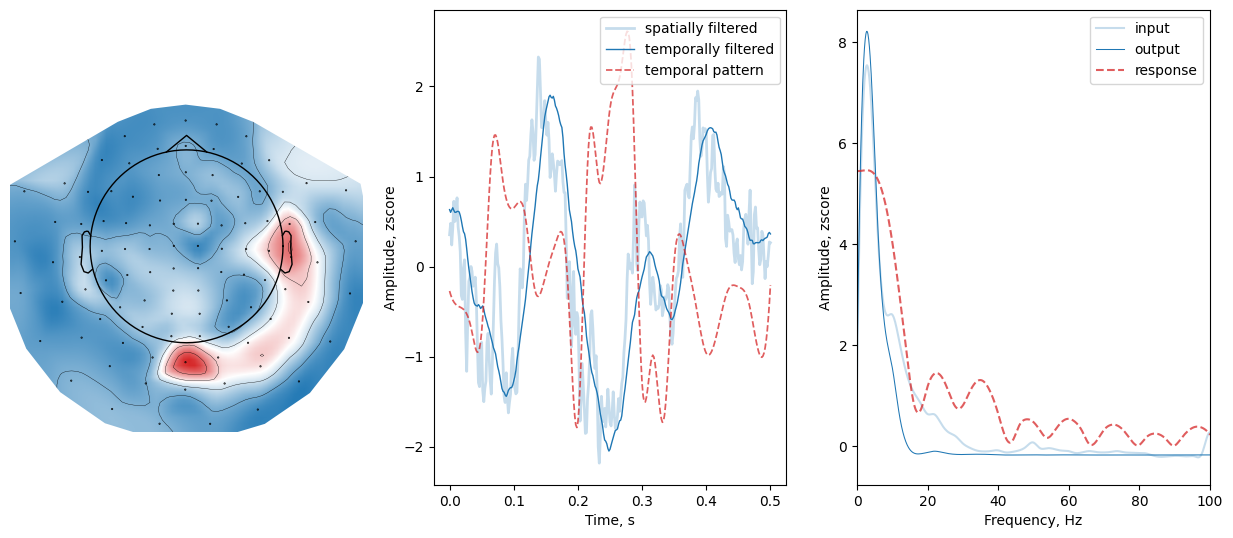

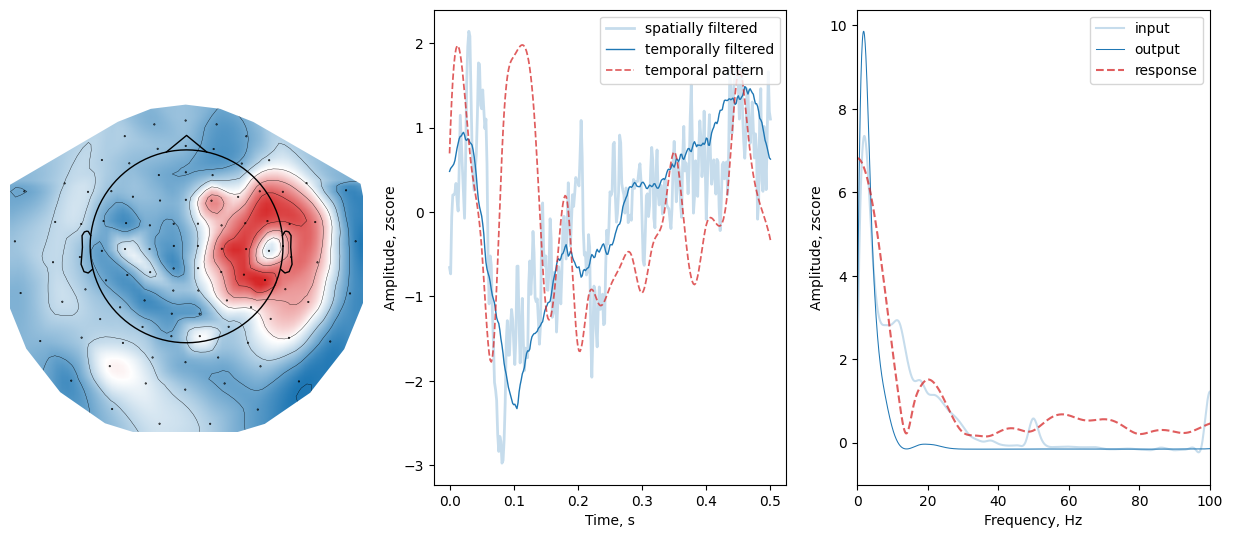

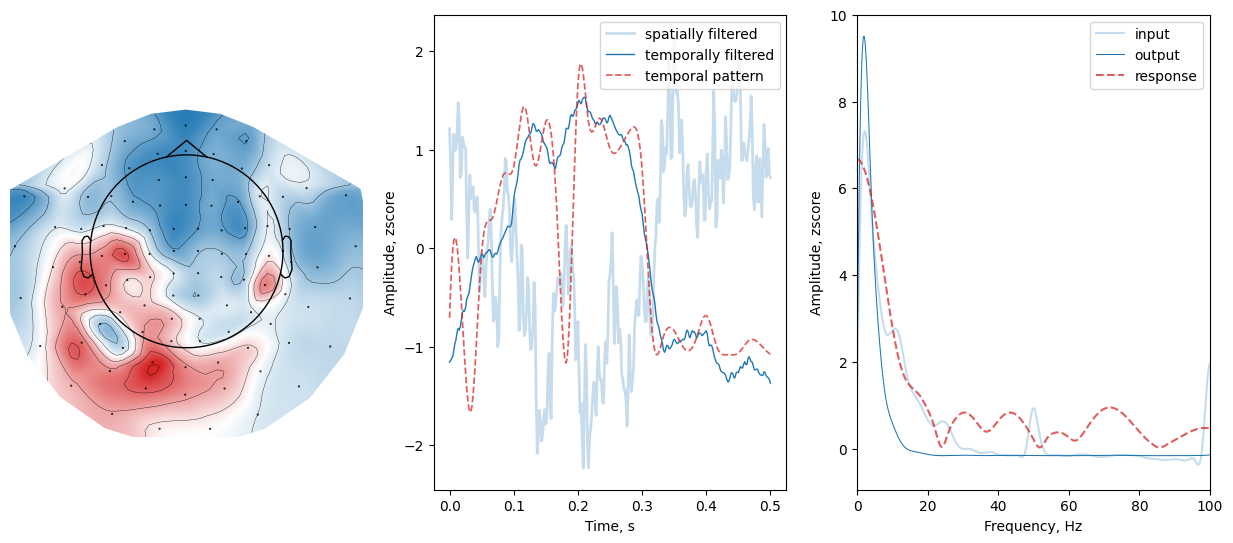

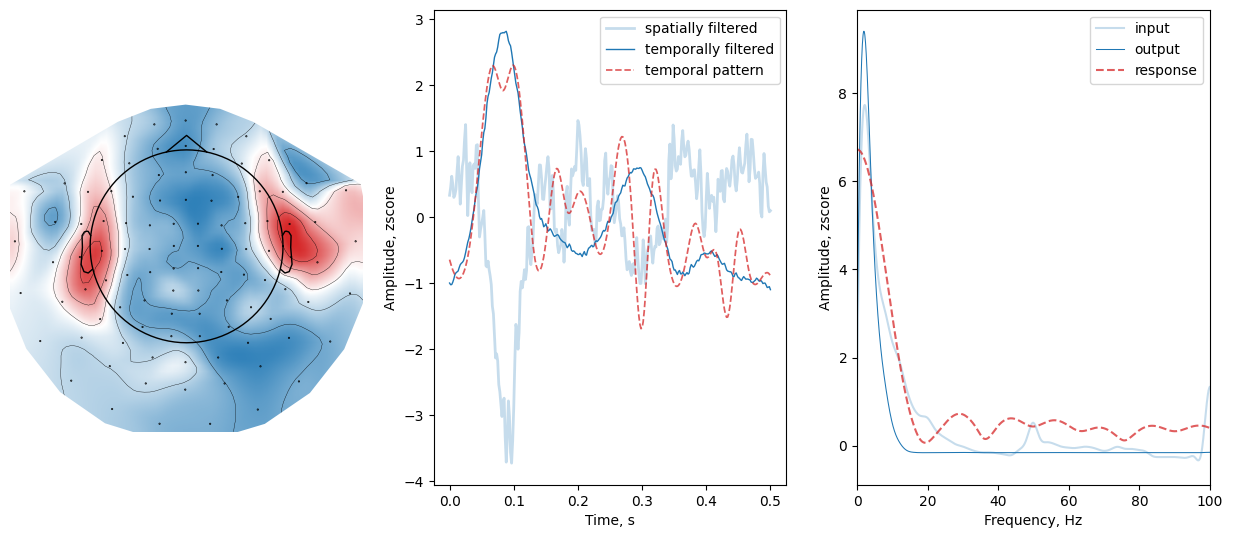

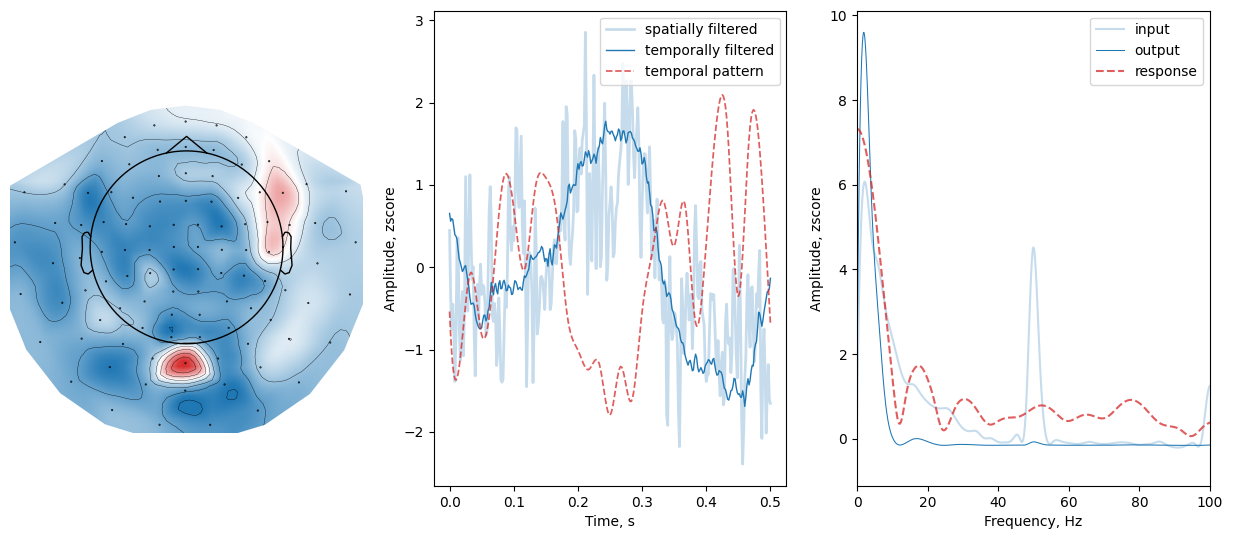

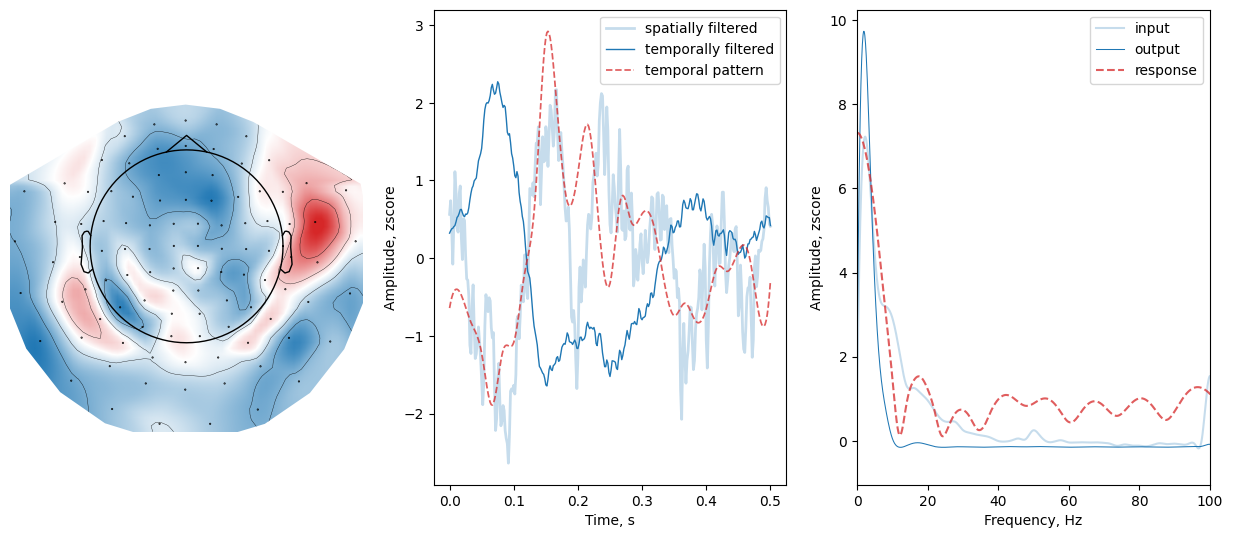

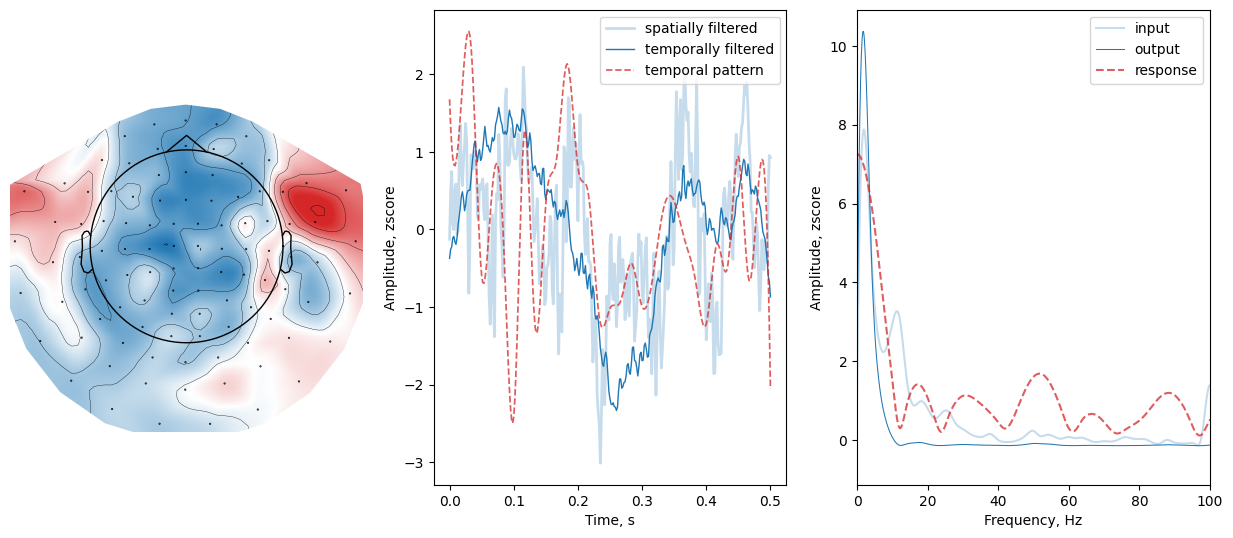

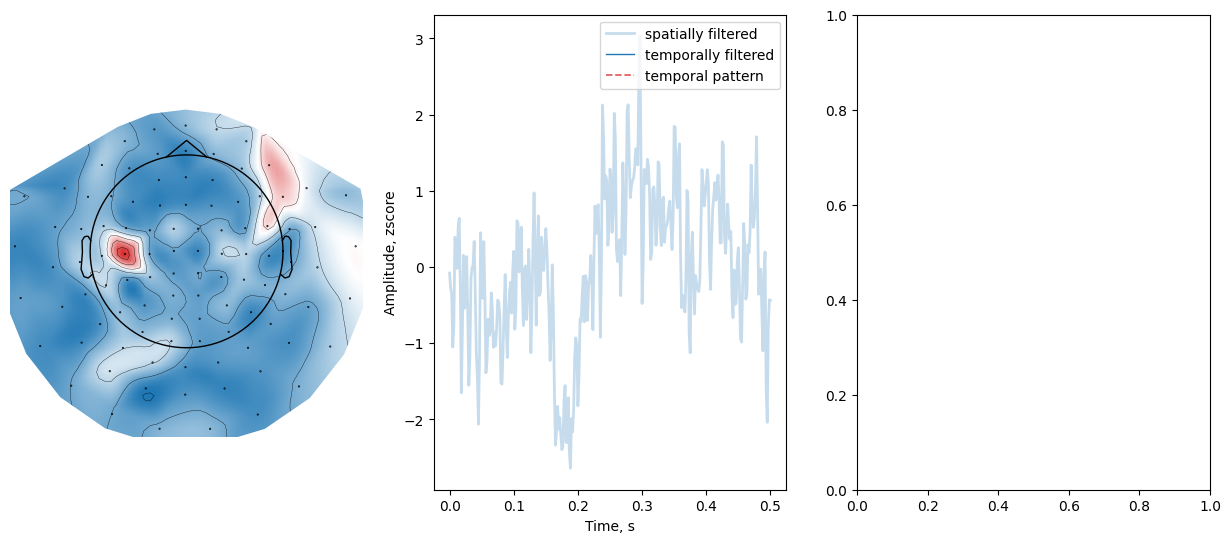

In [68]:
interpreter = LFCNNWrInterpreter(model, test, info)
for i in range(8):
    fig = interpreter.plot_branch(i, title=True)
    plt.show()

In [149]:
def set_ticks_invisible(ax, side='x'):
    if side == 'x':
        axis = ax.xaxis
    elif side == 'y':
        axis = ax.yaxis
    else:
        raise ValueError(f'Incorret side "{side}", use x or y only')
    for tick in axis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)


def sample_spherical(x, y, z):
    vec = np.stack([x, y, z], axis=0)
    vec /= np.linalg.norm(vec, axis=0)
    return vec


def plot_latent_space(
    latent1: np.ndarray,
    latent2: np.ndarray,
    latent3: np.ndarray,
    target: np.ndarray
):

    assert len({len(i) for i in (latent1, latent2, latent3)}) == 1, f'given latent variables hase different samplings1: {len(latent1)}, {len(latent2)}, {len(latent3)}'
    assert len(target) == len(latent1), f'Target variable course has different sampling: {len(target)} ~ {len(latent1)}'

    xx, yy, zz = sample_spherical(latent1, latent2, latent3)

    fig = plt.figure()
    sfig1, sfig2 = fig.subfigures(1, 2, wspace=0.07)

    gs1 = sfig1.add_gridspec(3, 5)
    gs2 = sfig2.add_gridspec(5, 5)

    ax1 = sfig1.add_subplot(gs1[0, :])
    ax2 = sfig1.add_subplot(gs1[1, :])
    ax3 = sfig1.add_subplot(gs1[2, :])

    ax1.plot(target, latent1)
    ax1.set_ylabel('latent 1')
    set_ticks_invisible(ax1)
    ax2.plot(target, latent2)
    ax2.set_ylabel('latent 2')
    set_ticks_invisible(ax2)
    ax3.plot(target, latent3)
    ax3.set_ylabel('latent 3')
    ax3.set_xlabel('time')

    ax4 = sfig2.add_subplot(gs2[:, :], projection='3d')

    m = ax4.scatter(
        xx, yy, zz,
        c=target,
        cmap='cool'
    )
    ax4.set_xlabel('latent 1')
    ax4.set_ylabel('latent 2')
    ax4.set_zlabel('latent 3')

    ax5 = sfig2.add_subplot(gs2[0, 0:2])

    c = ax5.imshow(
        np.corrcoef(np.stack([
            latent1,
            latent2,
            latent3
        ])),
        cmap='seismic',
        vmin=-1, vmax=1
    )
    set_ticks_invisible(ax5, side='x')
    set_ticks_invisible(ax5, side='y')

    plt.colorbar(m, ax=ax4, location='bottom', aspect=50, fraction=0.02)
    plt.colorbar(c, ax=ax5, location='right')

    return fig


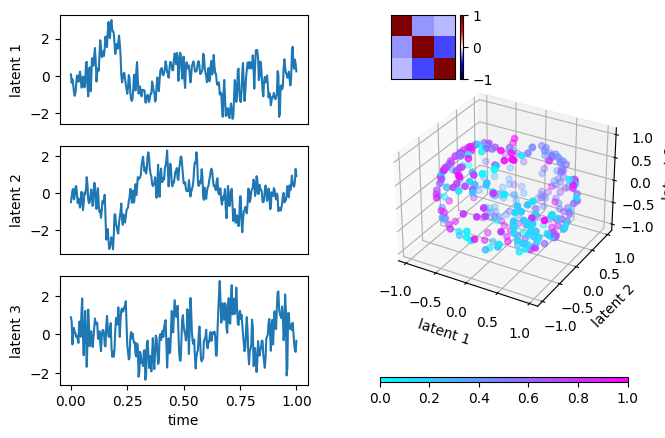

In [165]:
%matplotlib qt

time_courses_filtered = interpreter.latent_sources[:, np.argsort(interpreter.branchwise_loss), :]
times = np.linspace(0, 1, time_courses_filtered.shape[-1])


plot_latent_space(
    sp.stats.zscore(time_courses_filtered.mean(0)[-1]),
    sp.stats.zscore(time_courses_filtered.mean(0)[-2]),
    sp.stats.zscore(time_courses_filtered.mean(0)[-3]),
    times
)

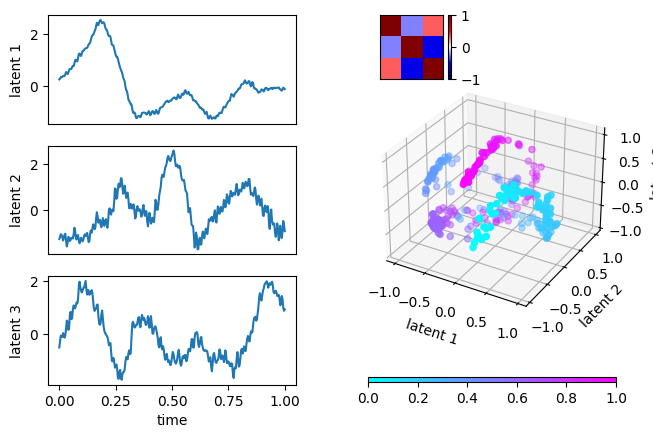

In [162]:
%matplotlib qt

time_courses_filtered = interpreter.latent_sources_filtered[:, np.argsort(interpreter.branchwise_loss), :]
times = np.linspace(0, 1, time_courses_filtered.shape[-1])


plot_latent_space(
    sp.stats.zscore(time_courses_filtered[3][0]),
    sp.stats.zscore(time_courses_filtered[3][1]),
    sp.stats.zscore(time_courses_filtered[3][2]),
    times
)

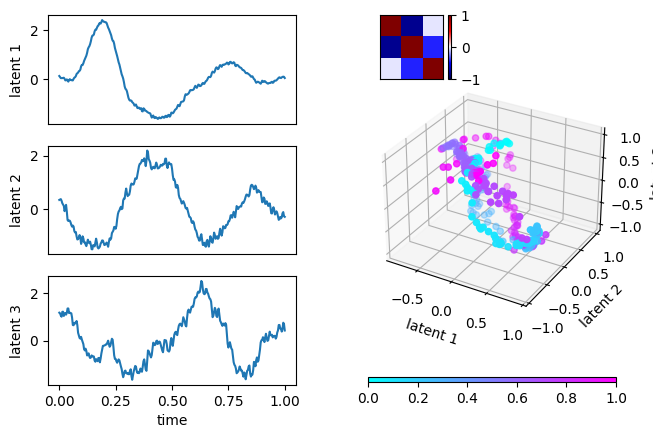

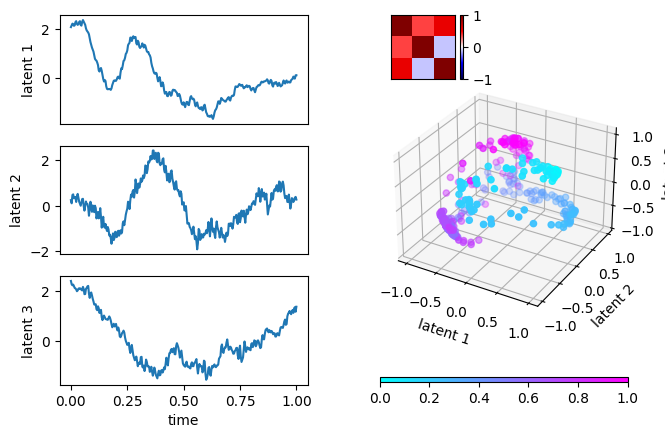

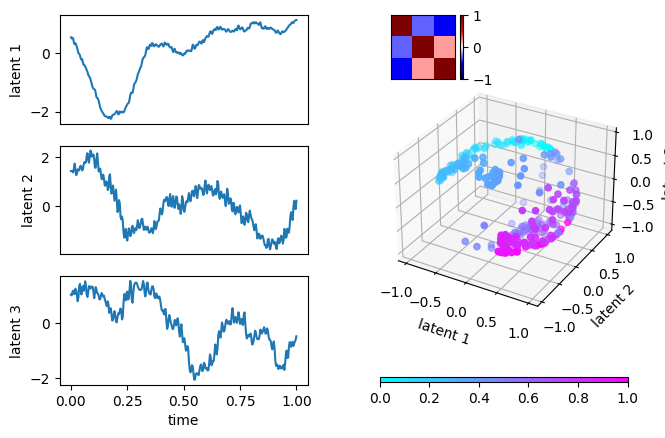

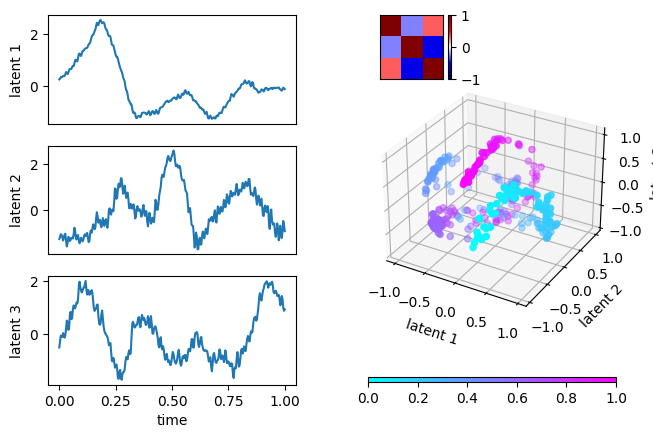

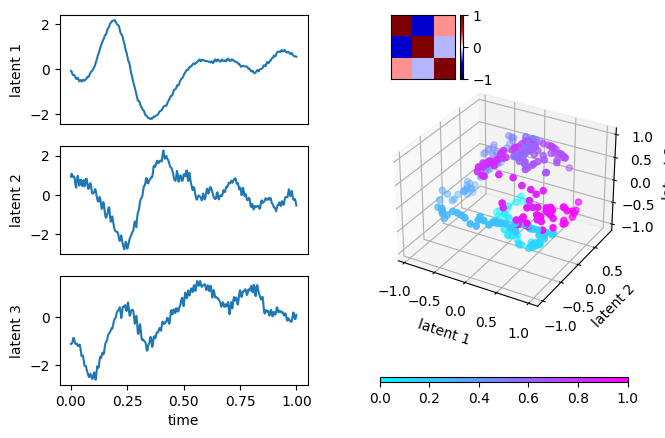

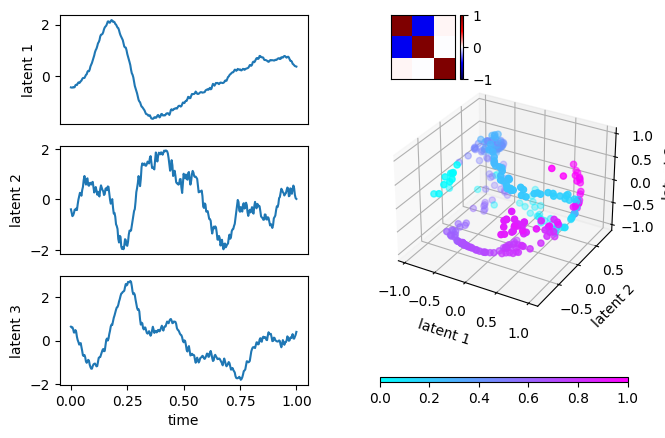

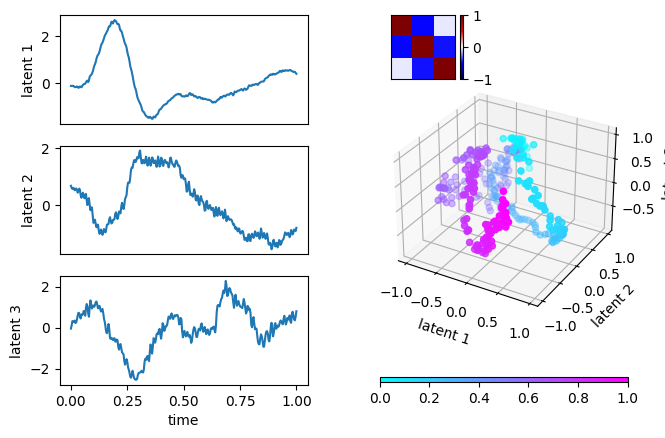

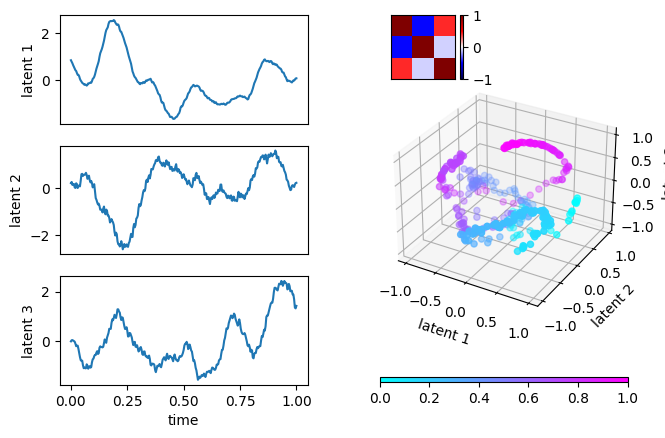

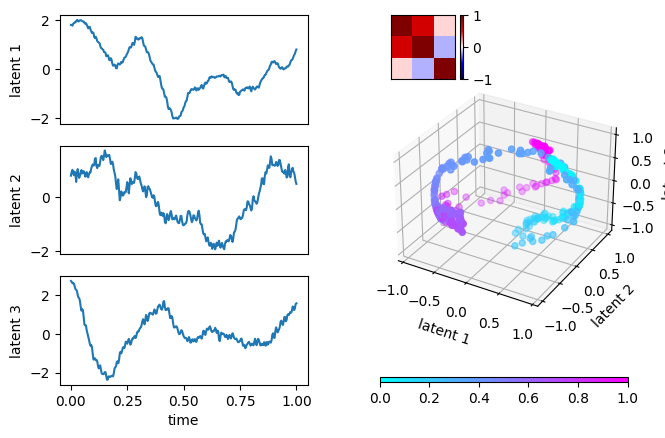

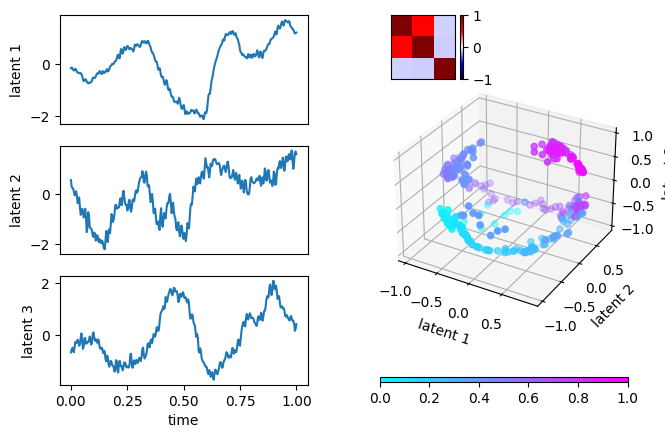

In [160]:
%matplotlib inline

n = 2
for n in range(10):
    plot_latent_space(
        sp.stats.zscore(time_courses_filtered[n][0]),
        sp.stats.zscore(time_courses_filtered[n][1]),
        sp.stats.zscore(time_courses_filtered[n][2]),
        times
    )
    plt.show()

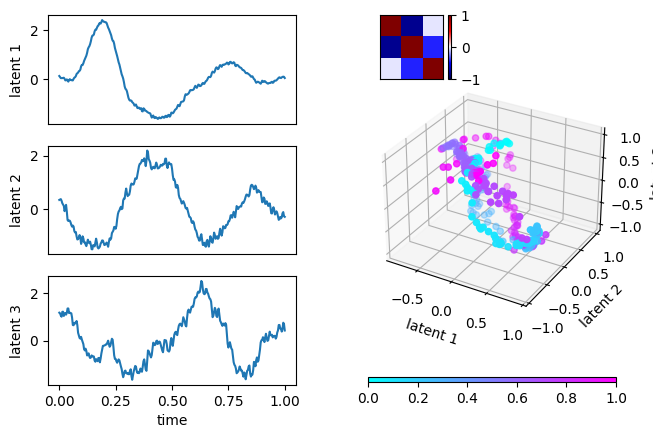

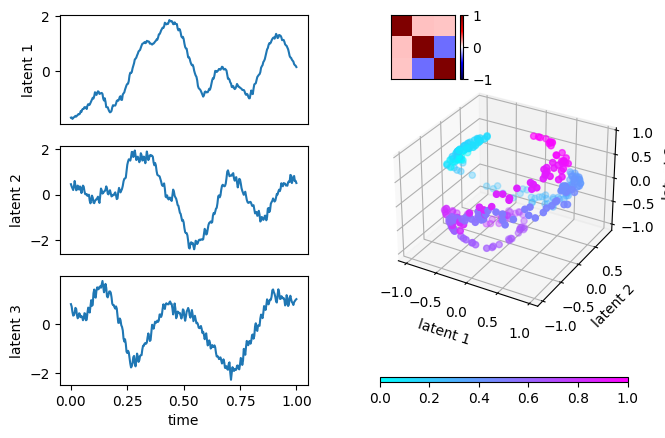

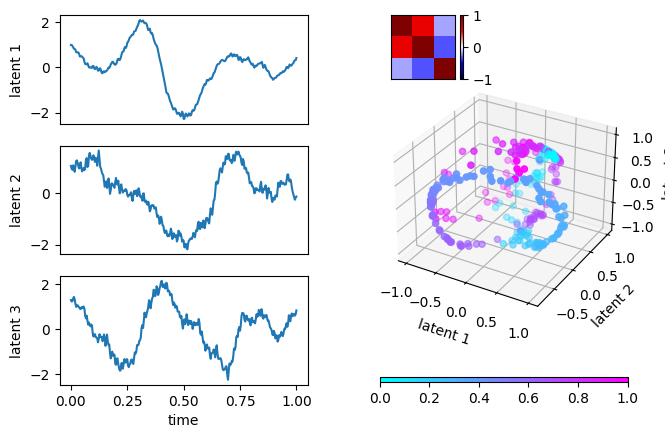

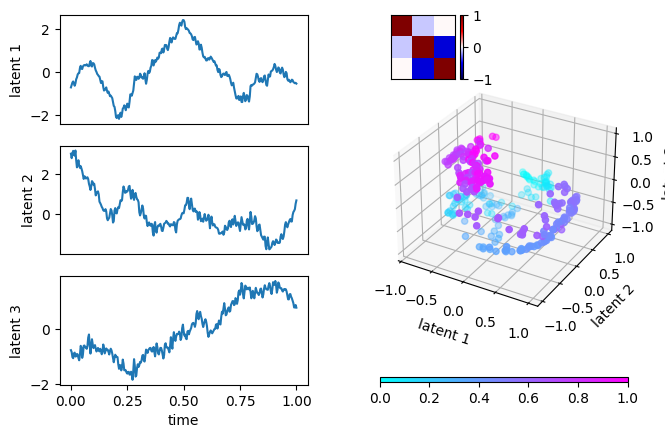

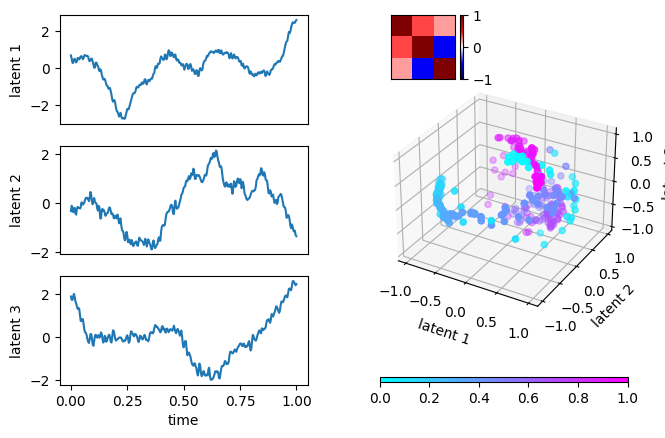

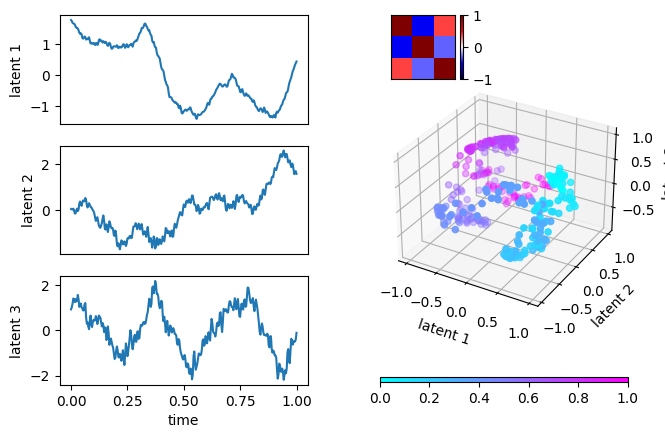

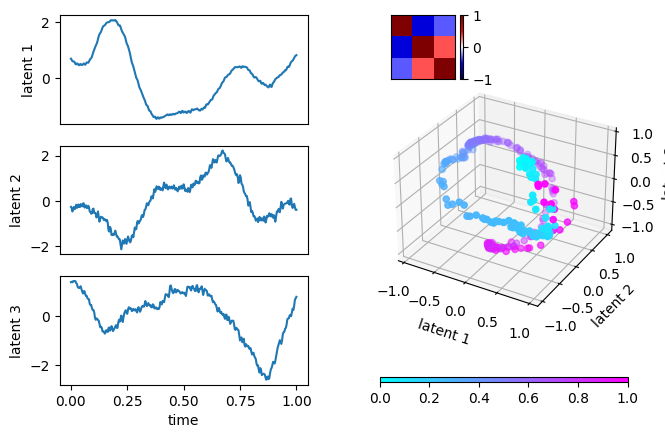

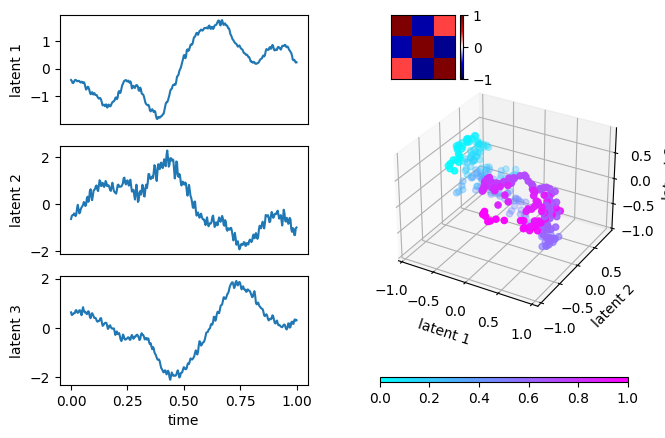

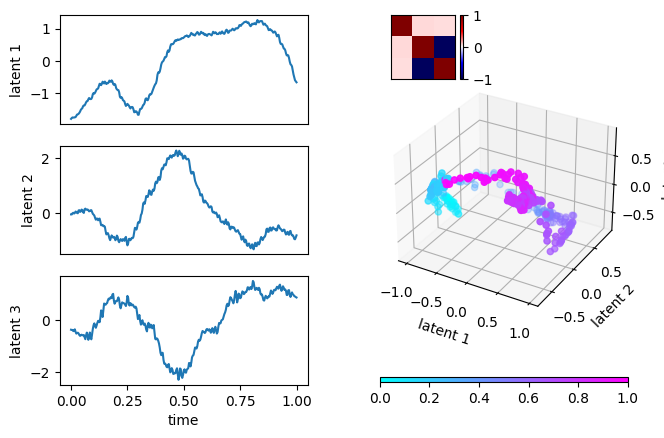

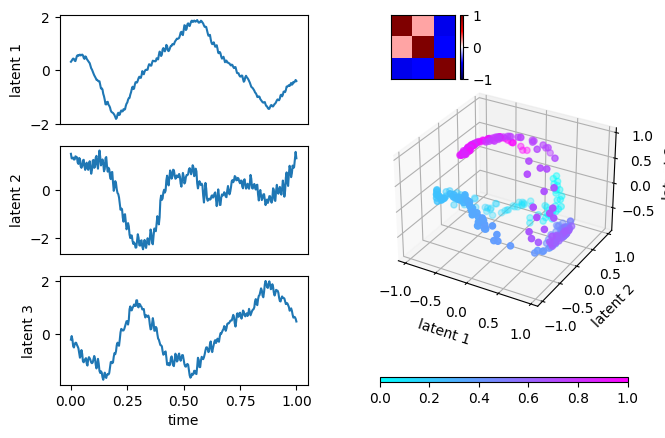

In [161]:
%matplotlib inline

n = 2
for n in range(10):
    plot_latent_space(
        sp.stats.zscore(time_courses_filtered[-n][0]),
        sp.stats.zscore(time_courses_filtered[-n][1]),
        sp.stats.zscore(time_courses_filtered[-n][2]),
        times
    )
    plt.show()